# Part 1: Training an LSTM Convolutional Neural Network

In [ ]:
# If on huge server without tensorflow
#!pip install tensorflow

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-12-09 19:59:12.842564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [22]:
input_train = xr.open_dataset(os.path.join(train_path,'oc_forcing_train.nc'),decode_times=False)
input_test = xr.open_dataset(os.path.join(test_path,'oc_forcing_test.nc'),decode_times=False)
input_train = input_train.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))
input_test = input_test.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))

In [23]:
input_train_temp = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test_temp = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))
X_train_xr = xr.merge([input_train,input_train_temp]).drop_dims('nv2').drop_vars(['basins','salinity_ocean','mapping'])
X_test_xr = xr.merge([input_test,input_test_temp]).drop_dims('nv2').drop_vars(['basins','salinity_ocean','mapping'])


In [24]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

output_train = output_train.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))
output_test = output_test.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))

In [25]:
y_train_np = output_train['velsurf_mag'].fillna(-1).data
y_test_np  = output_test['velsurf_mag'].fillna(-1).data

In [26]:
# Compute mean/std of each variable for the whole dataset
meanstd_inputs = {}
predictors     = ['theta_ocean','delta_T']
for var in predictors:
    meanstd_inputs[var] = (X_train_xr[var].data.mean(),X_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = X_train_xr[var].dims
    X_train_xr = X_train_xr.assign({var: (var_dims, normalize(X_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = X_test_xr[var].dims
    X_test_xr = X_test_xr.assign({var: (var_dims, normalize(X_test_xr[var].data, var, meanstd_inputs))})

In [27]:
X_train_np = X_train_xr.to_array().transpose('time', 'x', 'y', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'x', 'y', 'variable').data

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(300, 380, 380, 2) (300, 380, 380) (100, 380, 380, 2) (100, 380, 380)


In [28]:
X_length = np.array([len(X_train_np)])

In [29]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 3
n_samples   = X_train_np.shape[0] - (slider-1)*len(X_length)
n_lat,n_lon,n_feature = X_train_np.shape[1:]

X_train = np.zeros([n_samples,slider,n_lat,n_lon,n_feature])
y_train = np.zeros([n_samples,1,n_lat,n_lon])

n_start = 0
for i in range(len(X_length)):
    
    X_subset = X_train_np[start[i]:end[i],:]
    y_subset = y_train_np[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    # print(X_subset.shape,y_subset.shape)
    n_length = X_subset.shape[0]
    X_train[n_start:n_start+n_length,:,:,:,:] = X_subset
    y_train[n_start:n_start+n_length,:,:,:]   = y_subset
    n_start += n_length
    
X_test  = np.array([X_test_np[i:i+slider] for i in range(0, X_test_np.shape[0]-slider+1)])


In [30]:
print(X_train.shape,y_train.shape,X_test.shape)

(298, 3, 380, 380, 2) (298, 1, 380, 380) (98, 3, 380, 380, 2)


In [31]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [32]:
n_filters   = 32 # number of filters
kernel_size = 5  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 15 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.01 # learning rate
minibatch_size = 16   # batch size
num_epochs     = 50   # number of total epochs

In [33]:
model = Sequential()

model.add(Input(shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(n_lstm_unit, activation=activation))
model.add(Dense(n_lat*n_lon))
model.add(Activation('linear'))
model.add(Reshape((1, n_lat, n_lon)))


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 3, 380, 380, 32)  1632      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 3, 190, 190, 32)  0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 3, 32)            0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 15)                2880      
                                                                 
 dense_1 (Dense)             (None, 144400)            2310400   
                                                      

In [34]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
15/15 [==============================] - 7s 299ms/step - loss: 191.8223 - val_loss: 126.1930
Epoch 2/50
15/15 [==============================] - 2s 129ms/step - loss: 135.1006 - val_loss: 95.6346
Epoch 3/50
15/15 [==============================] - 2s 119ms/step - loss: 105.3855 - val_loss: 92.0134
Epoch 4/50
15/15 [==============================] - 2s 119ms/step - loss: 98.6659 - val_loss: 96.2402
Epoch 5/50
15/15 [==============================] - 2s 120ms/step - loss: 95.8810 - val_loss: 91.2312
Epoch 6/50
15/15 [==============================] - 2s 120ms/step - loss: 94.8535 - val_loss: 93.2367
Epoch 7/50
15/15 [==============================] - 2s 119ms/step - loss: 94.4783 - val_loss: 94.7029
Epoch 8/50
15/15 [==============================] - 2s 119ms/step - loss: 94.3729 - val_loss: 90.3929
Epoch 9/50
15/15 [==============================] - 2s 120ms/step - loss: 94.0550 - val_loss: 89.6500
Epoch 10/50
15/15 [==============================] - 2s 120ms/step - loss: 93.

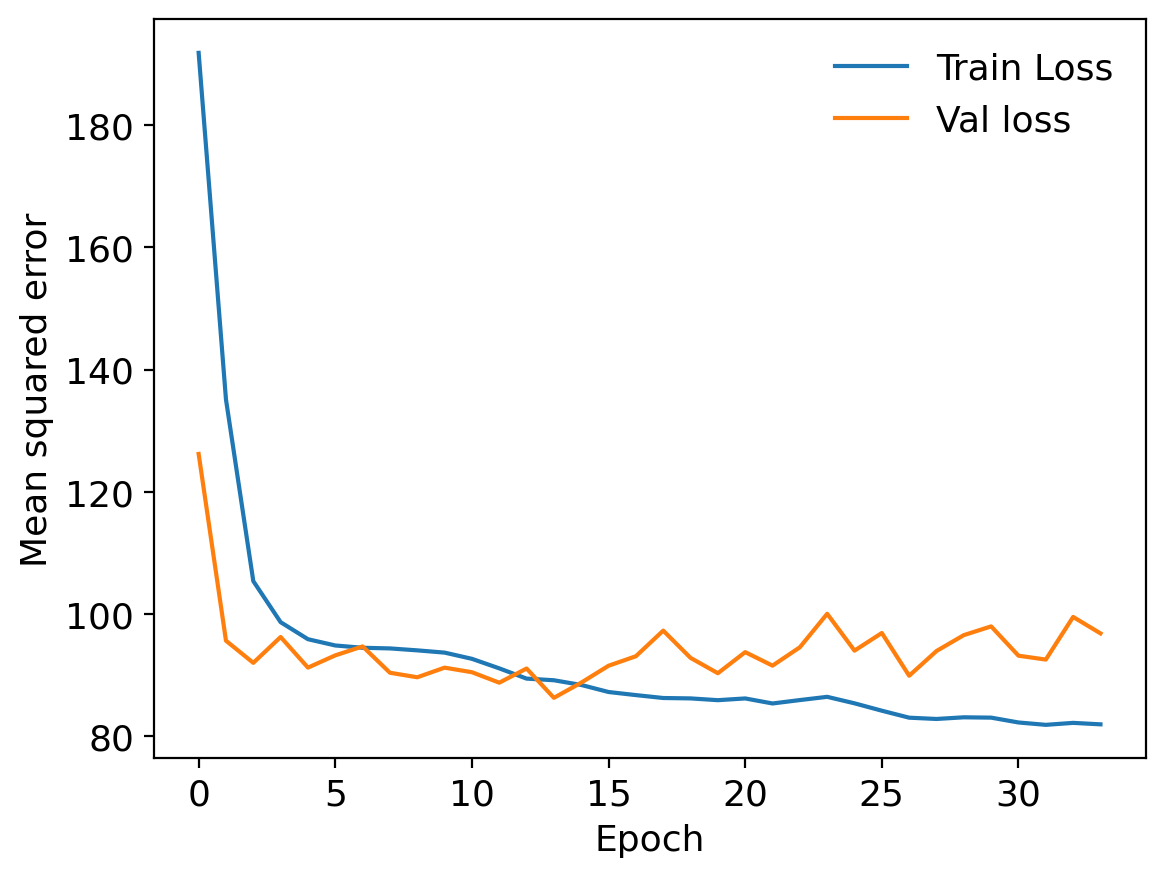

In [35]:
plot_history(history)

In [ ]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [ ]:
model.save(os.path.join(model_path,'CNNLSTM_model_1_member.h5'))

## Testing

In [ ]:
model = load_model(os.path.join(model_path,'CNNLSTM_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [36]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 380, 380)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'x': X_test_xr.x.values, 
                               'y': X_test_xr.y.values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre)))

4/4 [==============================] - 2s 82ms/step


In [37]:
y_test_pre = y_test_pre+output_test-output_test

In [38]:
y_test_pre

<xarray.Dataset>
Dimensions:      (time: 98, x: 380, y: 380)
Coordinates:
  * time         (time) float64 -8.46e+04 -8.45e+04 ... -7.5e+04 -7.49e+04
  * x            (x) float32 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y            (y) float32 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
Data variables:
    velsurf_mag  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

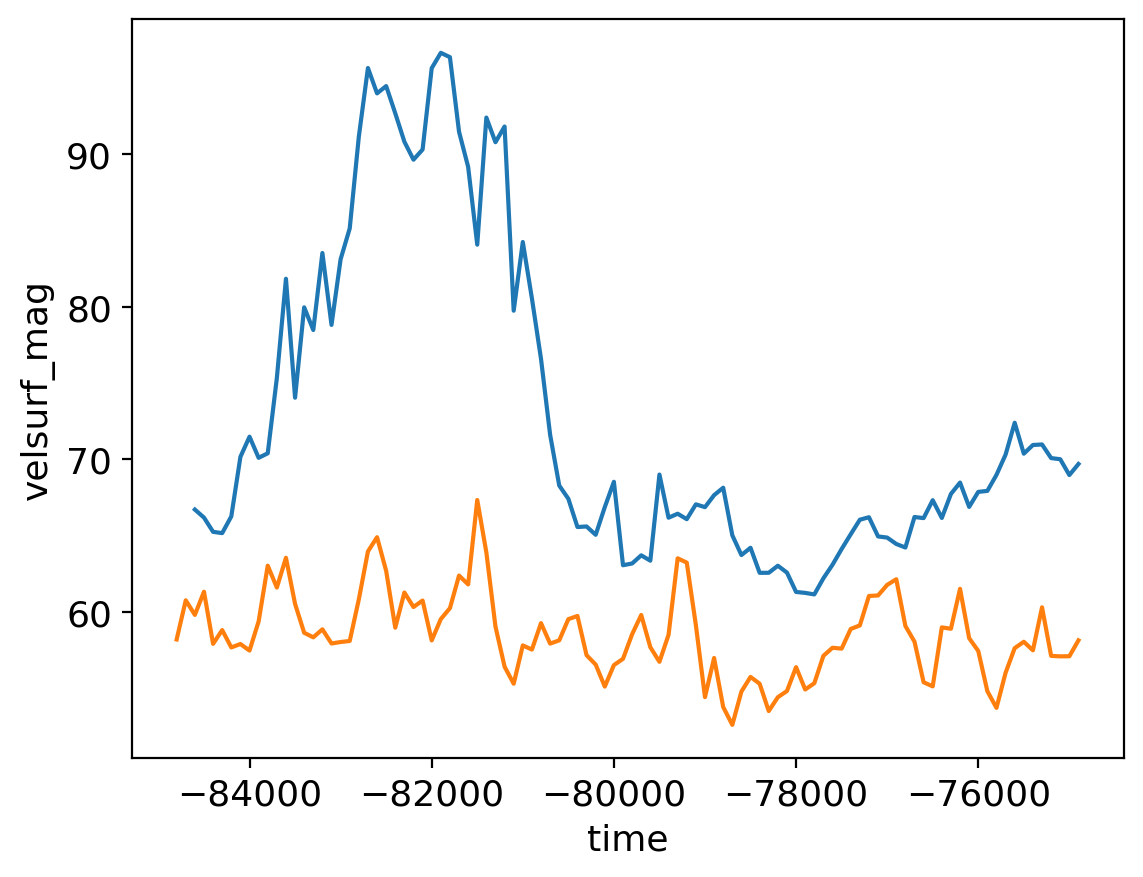

In [39]:
y_test_pre.velsurf_mag.mean(dim=['x','y']).plot()
output_test.velsurf_mag.mean(dim=['x','y']).plot()

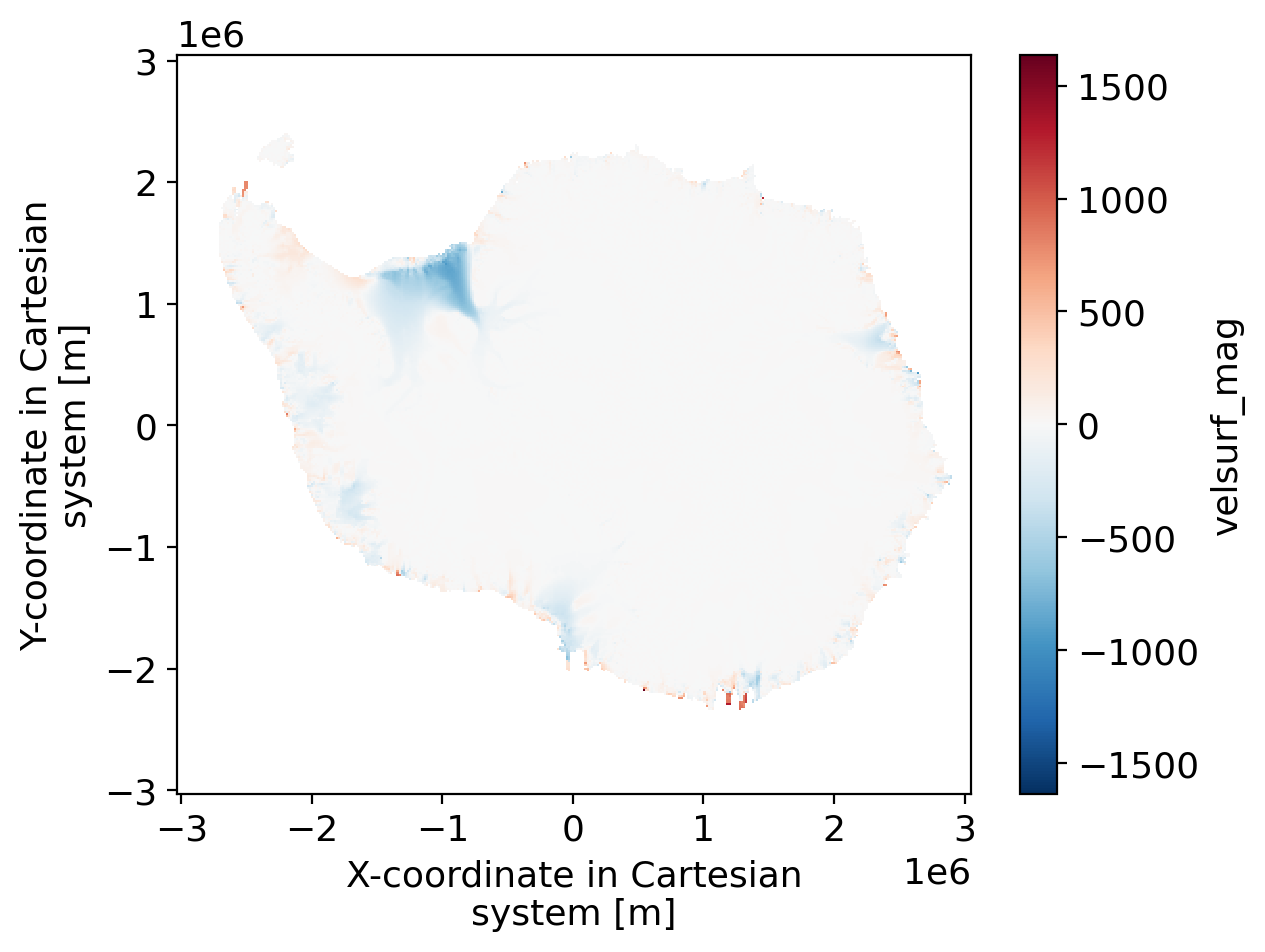

In [40]:
(output_test.velsurf_mag-y_test_pre.velsurf_mag).mean(dim='time').plot()

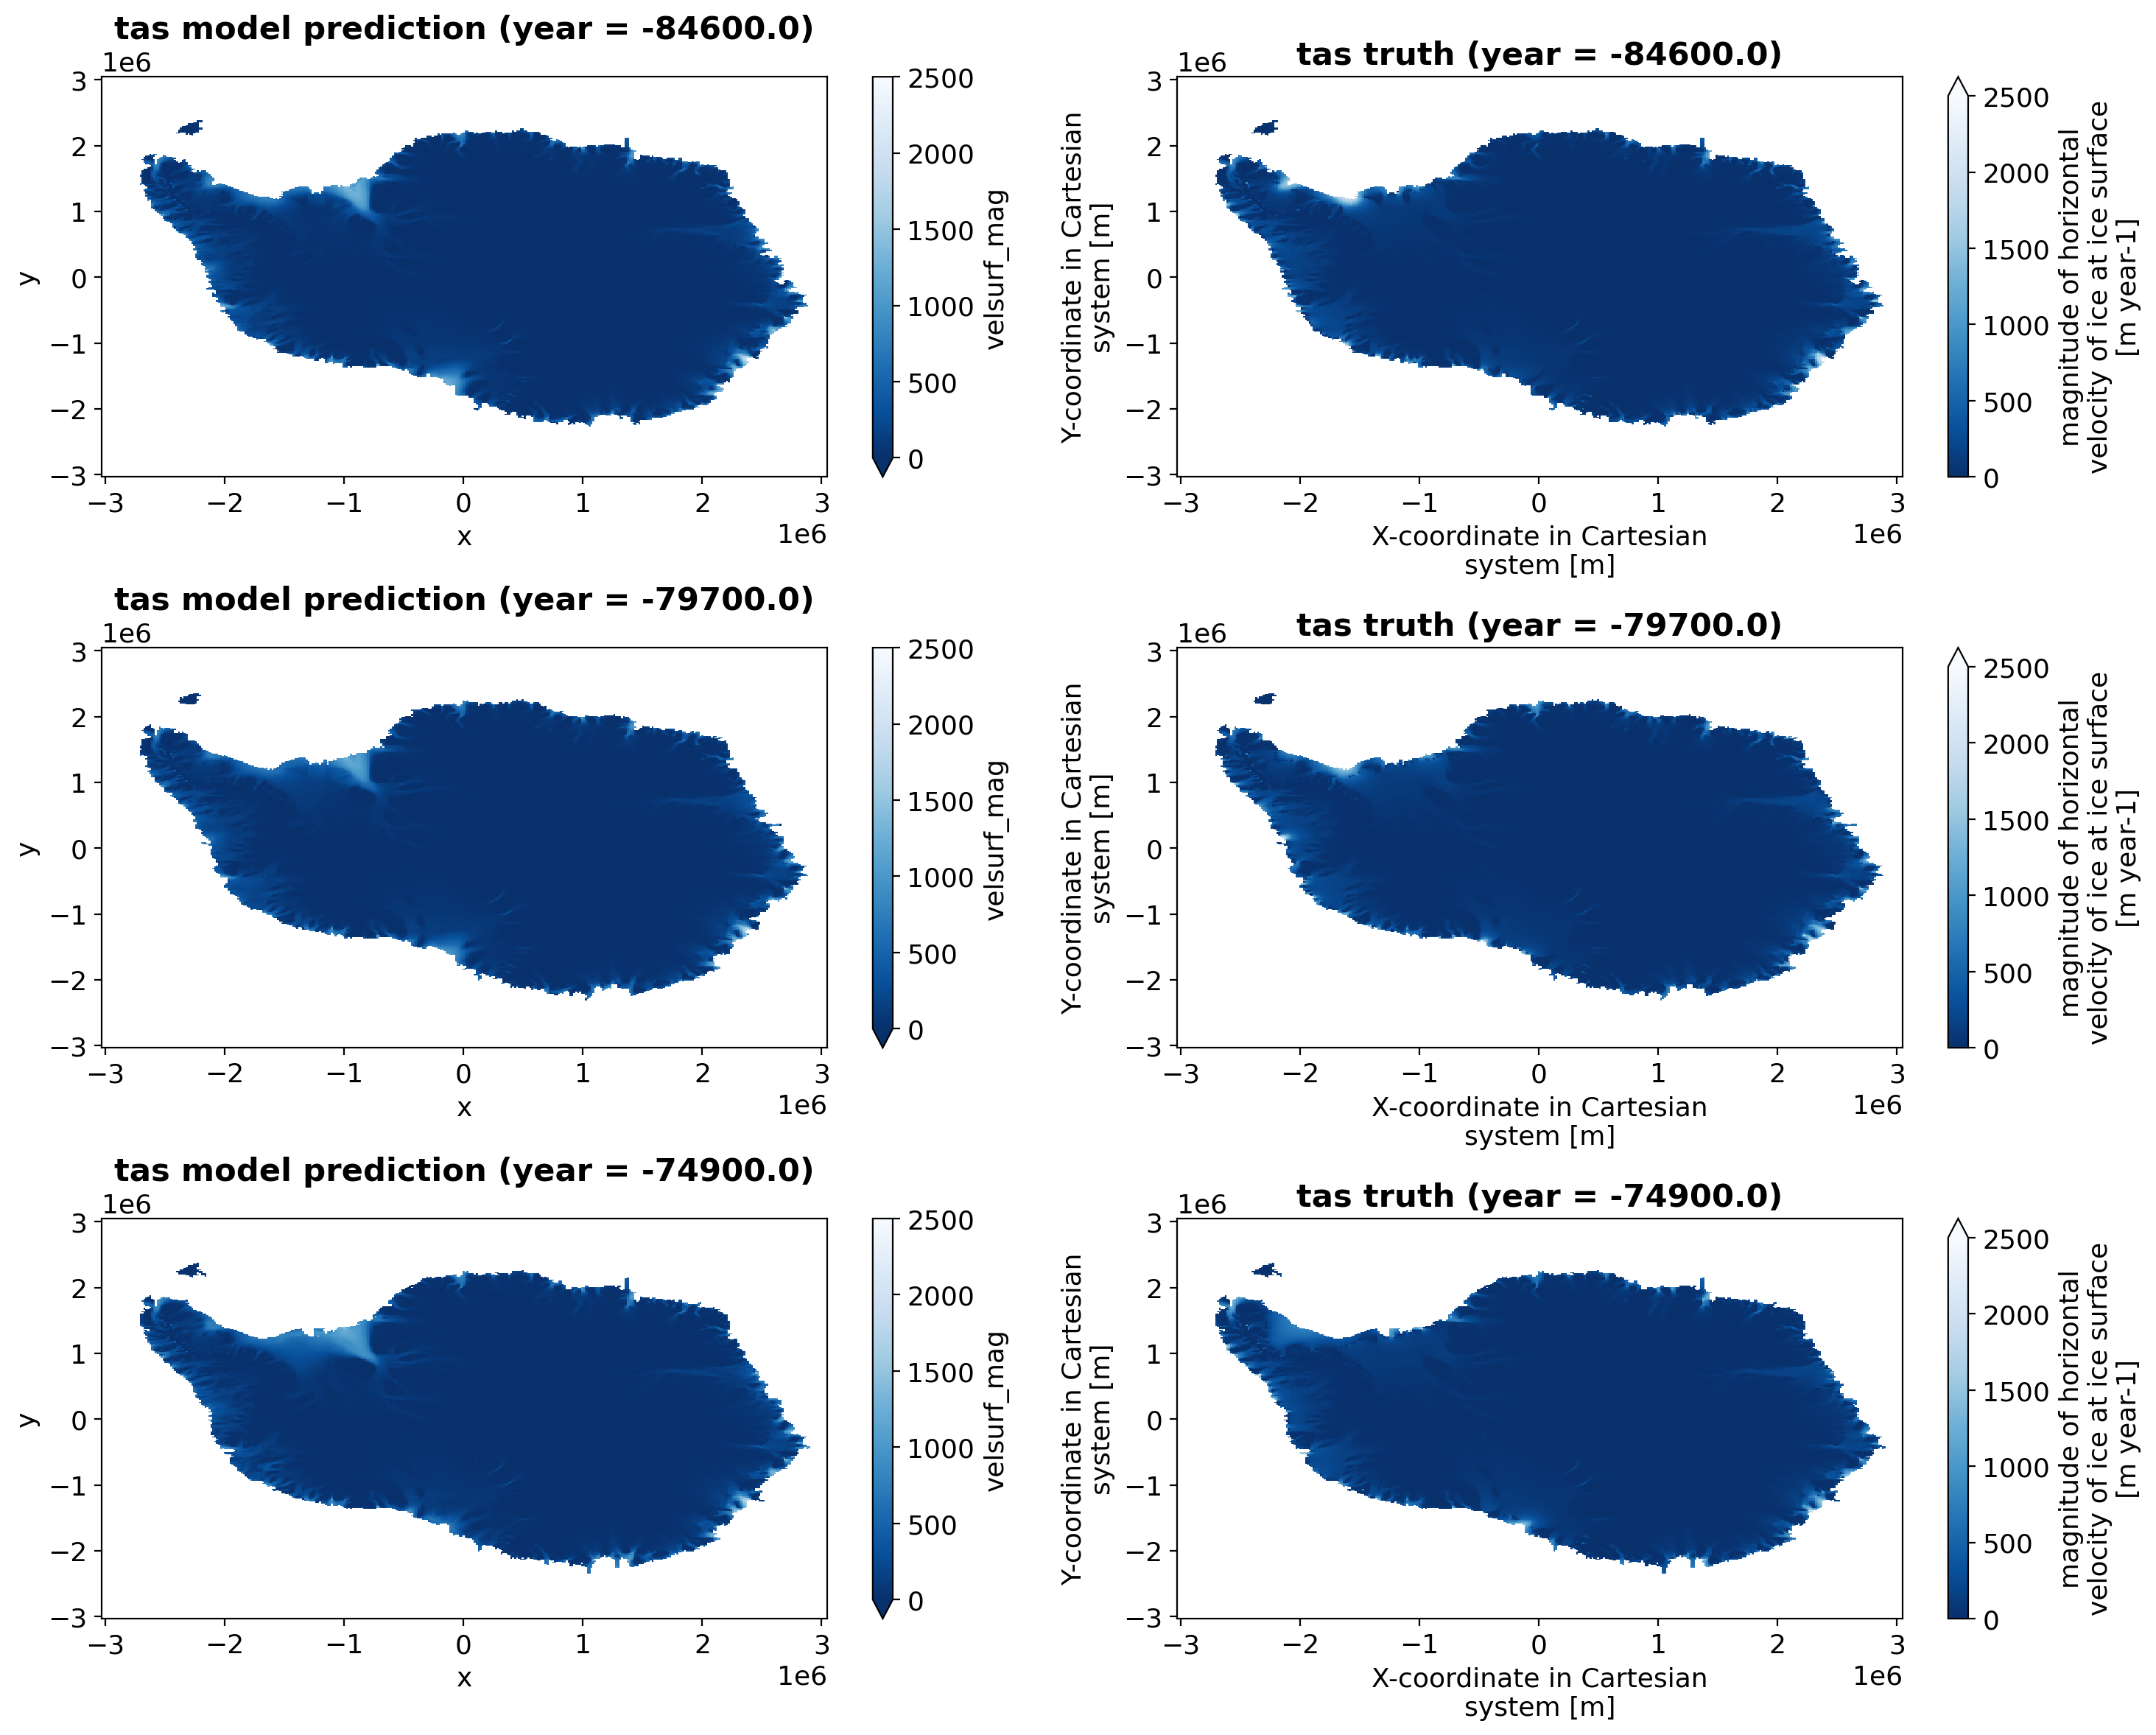

In [41]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [y_test_pre.time[0].values, y_test_pre.time[49].values, y_test_pre.time[-1].values]
vmin, vmax    = 0, 2500
cmap = 'Blues_r'
y_test_pre.velsurf_mag.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
output_test.velsurf_mag.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.velsurf_mag.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
output_test.velsurf_mag.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.velsurf_mag.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
output_test.velsurf_mag.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [ ]:
from matplotlib import animation

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
vmin, vmax    = 0, 2500
cmap = 'Blues_r'
diff_min,diff_max = -2500,2500
diff_map = 'RdBu_r'
plt_diff = (output_test.velsurf_mag.isel(time = 2)-y_test_pre.velsurf_mag.isel(time = 0)).plot(vmin=diff_min, vmax=diff_max,cmap=diff_map,cbar_kwargs={
        'extend':'neither'
    })

def animate(i):

    plt_diff.set_array(output_test.velsurf_mag.isel(time = i*4+1)-y_test_pre.velsurf_mag.isel(time = i*4))
    ax.set_title("Time = " + str(y_test_pre.time.values[i*4]))
anim = animation.FuncAnimation(fig, animate, frames=y_test_pre.time.size//4, repeat=True)


In [ ]:
from IPython.display import HTML, display

HTML(anim.to_jshtml())
